In [1]:
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import matplotlib.pyplot as plt

In [9]:
def image_to_texts(image, size=(320,320), east_path='frozen_east_text_detection.pb', min_confidence=0.5):
    orig = image.copy()
    (H, W) = image.shape[:2]
    (newW, newH) = size
    rW = W / float(newW)
    rH = H / float(newH)

    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    net = cv2.dnn.readNet(east_path)
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < min_confidence:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    texts_list = []
    for i,(startX, startY, endX, endY) in enumerate(boxes):
        # scale the bounding box coordinates based on the respective
        # ratios
        img_height, img_width = orig.shape[:2]
        startX = max(0, min(int(startX * rW), img_width - 1))
        startY = max(0, min(int(startY * rH), img_height - 1))
        endX = max(0, min(int(endX * rW), img_width - 1))
        endY = max(0, min(int(endY * rH), img_height - 1))
        texts_list.append((startX, startY, endX, endY))
    
    return texts_list


In [12]:
def image_to_texts_v2(image, size=(320, 320), east_path='frozen_east_text_detection.pb', min_confidence=0.5):
    orig = image.copy()
    (newW, newH) = size
    image = cv2.resize(image, (newW, newH))

    layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]
    net = cv2.dnn.readNet(east_path)
    blob = cv2.dnn.blobFromImage(image, 1.0, (newW, newH), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)

    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    for y in range(numRows):
        scoresData = scores[0, 0, y]
        xData0, xData1, xData2, xData3, anglesData = geometry[0, :, y]

        for x in range(numCols):
            if scoresData[x] < min_confidence:
                continue

            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle, cos, sin = anglesData[x], np.cos(anglesData[x]), np.sin(anglesData[x])
            h, w = xData0[x] + xData2[x], xData1[x] + xData3[x]

            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX, startY = int(endX - w), int(endY - h)

            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    boxes = non_max_suppression(np.array(rects), probs=confidences)
    texts_list = [(max(0, min(int(startX * orig.shape[1] / newW), orig.shape[1] - 1)),
                   max(0, min(int(startY * orig.shape[0] / newH), orig.shape[0] - 1)),
                   max(0, min(int(endX * orig.shape[1] / newW), orig.shape[1] - 1)),
                   max(0, min(int(endY * orig.shape[0] / newH), orig.shape[0] - 1))) for startX, startY, endX, endY in boxes]

    return texts_list

In [10]:
test_image = cv2.imread('./images/shirt.jpg')
boxes = image_to_texts(test_image)
print(boxes)

508 373 720 427
[(508, 373, 720, 427)]


In [21]:
def text_detection(image_path, size=(320, 320), east_path='frozen_east_text_detection.pb', min_confidence=0.5):
    # load the input image and grab the image dimensions
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = size
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    net = cv2.dnn.readNet(east_path)

    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))

    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < min_confidence:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    box_images = []

    # loop over the bounding boxes
    result = orig.copy()
    for i,(startX, startY, endX, endY) in enumerate(boxes):
        # scale the bounding box coordinates based on the respective
        # ratios
        img_height, img_width = orig.shape[:2]
        startX = max(0, min(int(startX * rW), img_width - 1))
        startY = max(0, min(int(startY * rH), img_height - 1))
        endX = max(0, min(int(endX * rW), img_width - 1))
        endY = max(0, min(int(endY * rH), img_height - 1))
        cropped_image = orig[startY:endY, startX:endX]
        box_images.append(cropped_image)

        # draw the bounding box on the image
        cv2.rectangle(result, (startX, startY), (endX, endY), (0, 255, 0), 2)
        cv2.putText(result, f'test {i}', (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return result, box_images

In [22]:
result_image, text_images = text_detection('./images/map.png', size=(320,320), min_confidence=0.9)
cv2.imshow("Text Detection", result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[INFO] loading EAST text detector...
[INFO] text detection took 0.277424 seconds


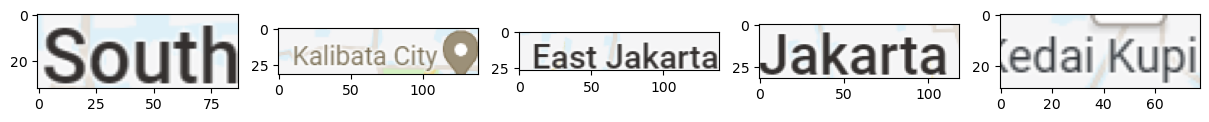

In [24]:
fig, axes = plt.subplots(1,5,figsize=(15,4))

for i,text_image in enumerate(text_images[:5]):
    axes.flatten()[i].imshow(text_image)

In [15]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

while True:
    ret, frame = cap.read()

    if not ret:
        print("Error: Failed to capture frame.")
        break

    texts = image_to_texts_v2(frame)

    # Draw rectangles around the detected faces
    for (startX, startY, endX, endY) in texts:
        cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # Display the frame with face detection
    cv2.imshow("Webcam with Face Detection", frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()

In [14]:
# Load the pre-trained Haar Cascade face classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Open a connection to the webcam (usually webcam index 0)
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Continuously capture frames from the webcam
while True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if not ret:
        print("Error: Failed to capture frame.")
        break

    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform face detection
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw rectangles around the detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the frame with face detection
    cv2.imshow("Webcam with Face Detection", frame)

    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()